# Introduction to OOP in Python, Part 3a

### More problems with *circular references*
How does the *garbage collector* clean up memory?

In languages like **C**, the programmer is responsible for correctly allocating an deallocating memory. This often lead to memory leaks and buffer over-runs due to human error. More modern programming languages, including Python, use automatic dynamic memory management generally referred to as *garbage collection*

In the simplest scheme, the *garbage collector* keeps track of the number of references to each object in memory. Once the reference count reaches zero, the object can be deleted and the memory freed. This is both fast and efficient, but cannot deal with circular references, i.e. when an object references itself either directly or indirectly.

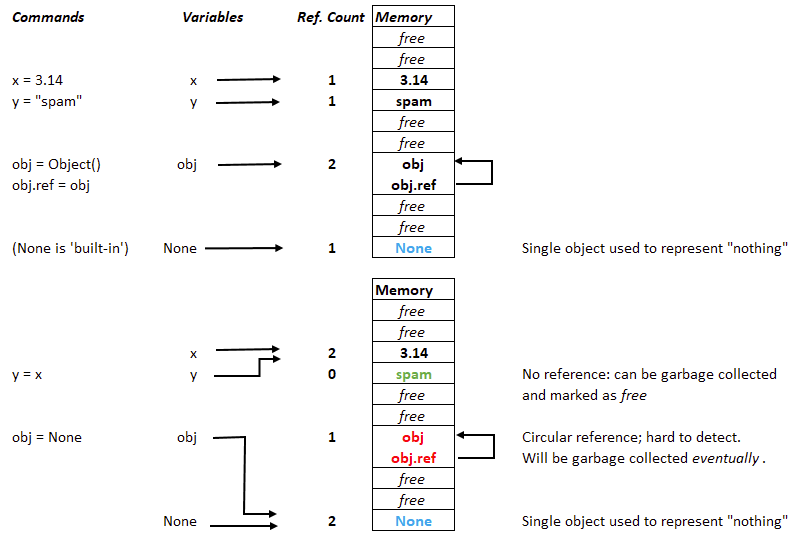

As well as ref. counting, the Python GC, uses another, more complex, algorithm to detect circular references and free up memory. As this is rather slow and much less efficient, it is only called periodically. Thus there is potential for large chunks of memory to left waiting for garbage collection.

We can monitor memory usage using the memory profiler. Using a double linked list test class which can exhibit circular references, we will illustrate the problem.

Notice the use of the <code> \_\_del\_\_ </code> method; this is called just before an instance is deleted, and is usually used to clean-up before object deletion e.g. deleting temporary files. Here we're using it to notify us that the object is being deleted.

In [1]:
%%file testmem.py
class DLL:
    # Double linked list
    
    def __init__(self,parent=None):
        self.parent = parent
        self.link = None
        # make each instance use up a reasonably large amount of memory ~128 MB.
        self.data = ' ' * 128 * 1024 * 1024
        
    def grow(self,d):
        if d==0:
            return
        self.link = DLL(parent=self)
        self.link.grow(d-1)
        return
    
    def __del__(self):
        print("delete")
       
def test():
    for _ in range(10):
        dll = DLL() #any previous 'dll' should be free to be deleted
        dll.grow(2)
        del(dll)
    print('End')


Overwriting testmem.py


Install memory_profiler if needed:
<code>!conda install memory_profiler</code>


The code to be profiled needs to be saved in a seperate file, in this case *testmem.py*

The memory profiler *IPython magic* **%mprun** is not loaded by default.

In [2]:
%load_ext memory_profiler

In [3]:
from testmem import test

In [4]:
%mprun -f test test()

End



Filename: D:\PythonClub\Python-Club\Tutorials\OOB_EC\testmem.py

Line #    Mem usage    Increment   Line Contents
    20     52.5 MiB     52.5 MiB   def test():
    21   3892.7 MiB      0.0 MiB       for _ in range(10):
    22   3636.7 MiB    128.1 MiB           dll = DLL() #any previous 'dll' should be free to be deleted
    23   3892.7 MiB    256.0 MiB           dll.grow(2)
    24   3892.7 MiB      0.0 MiB           del(dll)
    25   3892.7 MiB      0.0 MiB       print('End')

Curiously, it appears that <code>\_\_del\_\_</code> is never called and the memory usage is nearly 4 GB.

The weakref module allows the creation of references that **do not** count towards the garbage collector's ref count. Objects are therefore cleared from memory more quicky.

In [5]:
%%file testmem2.py
import weakref
   
class DLL2:
    
    # Double linked list
    
    def __init__(self,parent=None):
        self._parent = weakref.ref(parent) if parent else parent
        self.link = None
        self.data = ' ' * 128 * 1024 * 1024
    
    @property
    def parent(self):
        # if parent is None, return None
        if not self._parent:
            return self._parent
        # get the actual parent from the weakref
        _parent = self._parent()
        if _parent:
            return _parent
        else:
            # if _parent is None, something went wrong?!
            raise LookupError("Parent was destroyed")
        
    def grow(self,d):
        if d==0:
            return
        self.link = DLL2(parent=self)
        self.link.grow(d-1)
        return
    
    def __del__(self):
        print("delete")

    
def test2():
    for _ in range(10):
        dll = DLL2()
        dll.grow(2)
        del(dll)
    print('End')
    

Overwriting testmem2.py


In [6]:
from testmem2 import test2

Force garbage collector to free memory used by the previous test

In [7]:
import gc
gc.collect()

delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete


133

In [8]:
%mprun -f test2 test2()

delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
delete
End



Filename: D:\PythonClub\Python-Club\Tutorials\OOB_EC\testmem2.py

Line #    Mem usage    Increment   Line Contents
    36     52.7 MiB     52.7 MiB   def test2():
    37     52.7 MiB      0.0 MiB       for _ in range(10):
    38    180.7 MiB    128.0 MiB           dll = DLL2()
    39    436.7 MiB    256.0 MiB           dll.grow(2)
    40     52.7 MiB      0.0 MiB           del(dll)
    41     52.7 MiB      0.0 MiB       print('End')

We can now see the 'delete' messages and memory used by the dll objects is freed immediately.

### Use of weakref however has an effect on deepcopy:

Treenode2 contains a version of TreeNode that uses weak references to *parent*.

In [9]:
from mylib.TreeNode2 import TreeNode

TreeNode has loaded


In [10]:
from copy import deepcopy

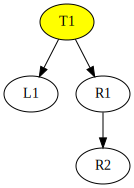

In [11]:
t1 = TreeNode('T1')
t1.left = TreeNode('L1')
t1.right = TreeNode('R1')
t1.right.right = TreeNode('R2')
t1.plot()

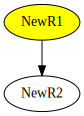

In [12]:
newr1 = deepcopy(t1.right)
newr1.name = 'NewR1'
newr1.right.name = 'NewR2'
newr1.plot()

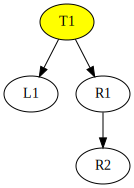

In [13]:
newr1.parent.plot()

Deepcopy *does not* follow weak references and **NewR1** points to the *wrong* parent, similarly for **NewR2**:

In [14]:
newr1 == newr1.right.parent

False

Still the old parent..

In [15]:
t1.right == newr1.right.parent

True

In [19]:
import weakref

Here we use a 'dunder' method, <code>\_\_deepcopy\_\_</code> to re-define how *deepcopy* works, and we make use of a dunder attribute <code>\_\_dict\_\_</code> that keeps track of an objects attributes.

Notice that **deepcopy** uses the **memo** parameter to keep track of objects it has 'already seen'; this prevent infinite loops.

In [32]:
#for example see:
t1.__dict__

{'name': 'T1',
 '_left': <__main__.TreeNode2 at 0x1ba691e8f48>,
 '_right': <__main__.TreeNode2 at 0x1ba691e8f88>,
 '_parent': None,
 '_value': 42,
 '_uid': '13'}

In [33]:
class TreeNode2(TreeNode):
    
    def __init__(self,name,parent=None):
        super().__init__(name,parent)
        
    def __deepcopy__(self,memo):
        new = object.__new__(type(self))
        memo[id(self)] = new
        new.__dict__.update(deepcopy(self.__dict__, memo))
        #manually deal with left and right parents:
        if new.right:
            new.right.parent = new
        if new.left:
            new.left.parent = new
        return new

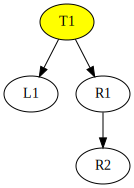

In [34]:
t1 = TreeNode2('T1')
t1.left = TreeNode2('L1')
t1.right = TreeNode2('R1')
t1.right.right = TreeNode2('R2')
t1.plot()

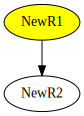

In [35]:
newr1 = deepcopy(t1.right)
newr1.name = 'NewR1'
newr1.right.name = 'NewR2'
newr1.plot()

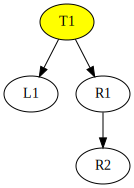

In [36]:
newr1.parent.plot()

With the custom Deepcopy, it *does not* follow weak references above the copied node and **NewR1** points to the *wrong* parent, however, weakrefernces at higher depth are copied properly. **NewR2** now points to the correct parent:

In [37]:
newr1 == newr1.right.parent

True

No longer the old parent..

In [38]:
t1.right == newr1.right.parent

False

We now have a deepcopy that properly copies a sub-branch of the tree.

## To be continued...